In [347]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm
from scipy import stats

from prophet import Prophet

In [348]:
sales_data = pd.read_csv('shop_sales.csv')
calendar_data = pd.read_csv('shop_sales_dates.csv')
prices_data = pd.read_csv('shop_sales_prices.csv')

In [349]:
prices_data

,store_id,item_id,wm_yr_wk,sell_price
0,STORE_2,STORE_2_085,11101,1.00
1,STORE_2,STORE_2_043,11101,2.88
2,STORE_2,STORE_2_054,11101,2.28
3,STORE_2,STORE_2_090,11101,1.25
4,STORE_2,STORE_2_252,11101,1.48
...,...,...,...,...
11136,STORE_1,STORE_1_584,11551,1.00
11137,STORE_1,STORE_1_586,11551,1.68
11138,STORE_1,STORE_1_587,11551,2.48
11139,STORE_1,STORE_1_714,11551,1.58


In [350]:
sales_data

,item_id,store_id,date_id,cnt
0,STORE_2_085,STORE_2,1,3
1,STORE_2_085,STORE_2,2,8
2,STORE_2_085,STORE_2,3,0
3,STORE_2_085,STORE_2,4,3
4,STORE_2_085,STORE_2,5,0
...,...,...,...,...
81850,STORE_1_727,STORE_1,1815,2
81851,STORE_1_727,STORE_1,1816,3
81852,STORE_1_727,STORE_1,1817,1
81853,STORE_1_727,STORE_1,1818,4


In [351]:
sales_data['week_id'] = (sales_data['date_id'] - 1) // 7 + 11101

# Объединение таблиц по item_id, store_id и соответствующим неделям
merged_data = pd.merge(sales_data, prices_data, how='left', 
                       left_on=['store_id', 'item_id', 'week_id'], 
                       right_on=['store_id', 'item_id', 'wm_yr_wk'])

# Удаление лишних столбцов
merged_data.drop(columns=['wm_yr_wk'], inplace=True)

In [352]:
merged_data

,item_id,store_id,date_id,cnt,week_id,sell_price
0,STORE_2_085,STORE_2,1,3,11101,1.0
1,STORE_2_085,STORE_2,2,8,11101,1.0
2,STORE_2_085,STORE_2,3,0,11101,1.0
3,STORE_2_085,STORE_2,4,3,11101,1.0
4,STORE_2_085,STORE_2,5,0,11101,1.0
...,...,...,...,...,...,...
81850,STORE_1_727,STORE_1,1815,2,11360,NaN
81851,STORE_1_727,STORE_1,1816,3,11360,NaN
81852,STORE_1_727,STORE_1,1817,1,11360,NaN
81853,STORE_1_727,STORE_1,1818,4,11360,NaN


In [353]:
customer = merged_data[(merged_data['store_id'] == 'STORE_1') & (merged_data['item_id'] == f'STORE_1_555')]
customer = pd.merge(customer, calendar_data, on='date_id', how='inner')
customer = customer.rename(columns={'date': 'ds', 'cnt': 'y'})
customer['sell_price'].interpolate(method='linear', inplace=True)
customer = customer[['ds', 'y', 'sell_price']]
customer['ds'] = pd.to_datetime(customer['ds'])
customer

,ds,y,sell_price
0,2011-01-29,51,1.48
1,2011-01-30,45,1.48
2,2011-01-31,25,1.48
3,2011-02-01,39,1.48
4,2011-02-02,23,1.48
...,...,...,...
1814,2016-01-17,17,1.58
1815,2016-01-18,9,1.58
1816,2016-01-19,15,1.58
1817,2016-01-20,22,1.58


In [354]:
# Объединение столбцов event_name_1 и event_name_2
calendar_data['event'] = calendar_data['event_name_1'].combine_first(calendar_data['event_name_2'])

# Удаление строк, где нет праздников
holidays_data = calendar_data.dropna(subset=['event'])

# Преобразование в формат, подходящий для Prophet
holidays = holidays_data[['date', 'event']]

holidays = holidays.rename(columns={'date': 'ds', 'event': 'holiday'})


In [355]:
holidays

,ds,holiday
8,2011-02-06,SuperBowl
16,2011-02-14,ValentinesDay
23,2011-02-21,PresidentsDay
39,2011-03-09,LentStart
46,2011-03-16,LentWeek2
...,...,...
1780,2015-12-14,Chanukah End
1791,2015-12-25,Christmas
1798,2016-01-01,NewYear
1804,2016-01-07,OrthodoxChristmas


<Axes: >

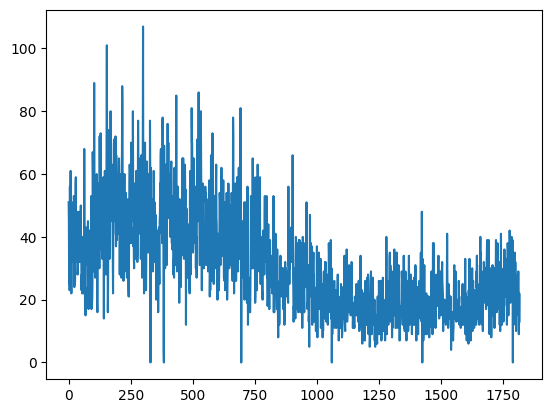

In [356]:
customer['y'].plot()

## Train test split

In [357]:
test_size = 30

customer_train = customer.iloc[:-test_size]
customer_test = customer.iloc[-test_size:]

In [358]:
m = Prophet(holidays=holidays) #, growth='linear', seasonality_mode='additive', holidays_prior_scale=20, seasonality_prior_scale=20
m.add_regressor('sell_price')
model = m.fit(customer_train)

18:24:37 - cmdstanpy - INFO - Chain [1] start processing
18:24:37 - cmdstanpy - INFO - Chain [1] done processing


## Forecast

In [359]:
# Прогноз на будущее
future = m.make_future_dataframe(periods=30, freq='D')

# Создание будущего датафрейма с регрессором
future = pd.merge(future, customer[['ds', 'sell_price']], on='ds', how='left')

# Заполнение пропущенных значений в будущем датафрейме
future['sell_price'].interpolate(method='linear', inplace=True)

# Прогнозирование
forecast = m.predict(future)

forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Chanukah End,Chanukah End_lower,Chanukah End_upper,Christmas,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2011-01-29,37.721887,35.175199,57.398551,37.721887,37.721887,0.0,0.0,0.0,0.0,...,9.488057,9.488057,9.488057,-2.873397,-2.873397,-2.873397,0.0,0.0,0.0,45.768958
1,2011-01-30,37.751355,28.466081,51.434670,37.751355,37.751355,0.0,0.0,0.0,0.0,...,3.169019,3.169019,3.169019,-2.322546,-2.322546,-2.322546,0.0,0.0,0.0,40.030239
2,2011-01-31,37.780824,22.239227,45.273300,37.780824,37.780824,0.0,0.0,0.0,0.0,...,-4.053747,-4.053747,-4.053747,-1.776340,-1.776340,-1.776340,0.0,0.0,0.0,33.383148
3,2011-02-01,37.810292,21.984653,45.681531,37.810292,37.810292,0.0,0.0,0.0,0.0,...,-3.831705,-3.831705,-3.831705,-1.240636,-1.240636,-1.240636,0.0,0.0,0.0,34.170363
4,2011-02-02,37.839761,21.808734,45.387491,37.839761,37.839761,0.0,0.0,0.0,0.0,...,-5.154322,-5.154322,-5.154322,-0.720705,-0.720705,-0.720705,0.0,0.0,0.0,33.397146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1814,2016-01-17,23.432562,7.243695,30.160504,23.402165,23.447038,0.0,0.0,0.0,0.0,...,3.169019,3.169019,3.169019,-7.358485,-7.358485,-7.358485,0.0,0.0,0.0,18.276084
1815,2016-01-18,23.442526,-1.477208,22.048035,23.407401,23.458006,0.0,0.0,0.0,0.0,...,-4.053747,-4.053747,-4.053747,-7.298397,-7.298397,-7.298397,0.0,0.0,0.0,10.246077
1816,2016-01-19,23.452491,-1.211544,22.466213,23.412548,23.469233,0.0,0.0,0.0,0.0,...,-3.831705,-3.831705,-3.831705,-7.166017,-7.166017,-7.166017,0.0,0.0,0.0,11.487758
1817,2016-01-20,23.462456,-1.058616,22.457280,23.417877,23.482776,0.0,0.0,0.0,0.0,...,-5.154322,-5.154322,-5.154322,-6.964884,-6.964884,-6.964884,0.0,0.0,0.0,10.376239


<Axes: >

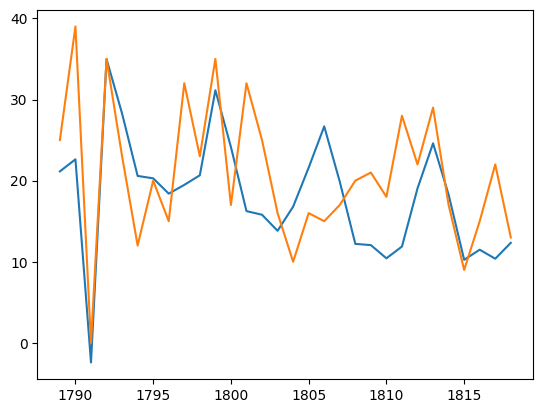

In [360]:
forecast['yhat'].tail(30).plot()
customer_test['y'].plot()

In [362]:
metrics_report(customer_test['y'], forecast['yhat'].tail(30))


,mean,median,quan_75,quan_95,std
maes,6.208454,4.831363,8.852917,15.956174,4.809186
maes_zero,6.746667,5.200000,10.200000,16.500000,5.294026
mapes,inf,29.211881,42.460554,75.024217,NaN
mapes_zero,inf,28.997845,40.142857,119.650000,NaN
r2,0.161242,0.161242,0.161242,0.161242,0.161242


In [363]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [364]:
mean_absolute_percentage_error(customer_test['y'], forecast['yhat'].tail(30))

inf

In [384]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pickle
import os

class RetailSalesPredictor:
    def __init__(self, sales_data, calendar_data, prices_data):
        self.sales_data = sales_data
        self.calendar_data = calendar_data
        self.prices_data = prices_data

    def preprocess_data(self, store_id, item_id):
        # Вычисление week_id
        self.sales_data['week_id'] = (self.sales_data['date_id'] - 1) // 7 + 11101

        # Объединение таблиц
        merged_data = pd.merge(self.sales_data, self.prices_data, how='left', 
                               left_on=['store_id', 'item_id', 'week_id'], 
                               right_on=['store_id', 'item_id', 'wm_yr_wk'])
        merged_data.drop(columns=['wm_yr_wk'], inplace=True)

        customer = merged_data[(merged_data['store_id'] == store_id) & (merged_data['item_id'] == item_id)]
        customer = pd.merge(customer, self.calendar_data, on='date_id', how='inner')
        customer = customer.rename(columns={'date': 'ds', 'cnt': 'y'})
        customer['sell_price'].interpolate(method='linear', inplace=True)
        customer = customer[['ds', 'y', 'sell_price']]
        customer['ds'] = pd.to_datetime(customer['ds'])

        # Объединение столбцов event_name_1 и event_name_2
        self.calendar_data['event'] = self.calendar_data['event_name_1'].combine_first(self.calendar_data['event_name_2'])
        
        # Удаление строк, где нет праздников
        holidays_data = self.calendar_data.dropna(subset=['event'])
        
        # Преобразование в формат, подходящий для Prophet
        holidays = holidays_data[['date', 'event']].rename(columns={'date': 'ds', 'event': 'holiday'})
        
        return customer, holidays

    def train_model(self, sales_data, holidays, test_size=30):
        if len(sales_data) <= test_size:
            raise ValueError("Not enough data to train the model. Please provide more data.")

        train_data = sales_data.iloc[:-test_size]
        test_data = sales_data.iloc[-test_size:]

        if len(train_data) < 2:
            raise ValueError("Not enough data to train the model. Please provide more data.")

        model = Prophet(holidays=holidays, yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
        model.add_regressor('sell_price')
        model.fit(train_data)

        return model, train_data, test_data

    def predict_and_evaluate(self, model, sales_data, test_data):
        future = model.make_future_dataframe(periods=len(test_data))
        future = future.merge(sales_data[['ds', 'sell_price']], on='ds', how='left')

        # Заполнение пропущенных значений в будущем датафрейме
        future['sell_price'].interpolate(method='linear', inplace=True)

        forecast = model.predict(future)
        forecast['yhat'] = forecast['yhat'].clip(lower=0)  # Ensure no negative predictions
        predicted = forecast[['ds', 'yhat']].tail(len(test_data))

        actual = test_data['y'].values
        predicted_values = predicted['yhat'].values

        mse = mean_squared_error(actual, predicted_values)
        mae = mean_absolute_error(actual, predicted_values)
        # Добавление малой константы к actual для вычисления MAPE
        mape = np.mean(np.abs((actual - predicted_values) / (actual + 0.001))) * 100

        print(f'Mean Squared Error: {mse}')
        print(f'Mean Absolute Error: {mae}')
        print(f'MAPE: {mape}%')

        fig1 = model.plot(forecast)
        plt.show()

        fig2 = model.plot_components(forecast)
        plt.show()

        # Визуализация тестовой части и предсказанных данных
        plt.figure(figsize=(10, 6))
        plt.plot(test_data['ds'], actual, label='Actual', marker='o')
        plt.plot(predicted['ds'], predicted_values, label='Predicted', marker='x')
        plt.title('Actual vs Predicted Sales')
        plt.xlabel('Date')
        plt.ylabel('Sales')
        plt.legend()
        plt.show()

        return mse, mae, mape

    def save_model(self, model, filename):
        with open(filename, 'wb') as file:
            pickle.dump(model, file)

    def load_model(self, filename):
        with open(filename, 'rb') as file:
            model = pickle.load(file)
        return model

    def forecast_period(self, store_id, item_id, period):
        sales_data, holidays = self.preprocess_data(store_id, item_id)
        available_data = len(sales_data)
        test_size = min(period, available_data - 2)  # Убедимся, что у нас достаточно данных для тренировки и тестирования
        if test_size < 1:
            raise ValueError("Not enough data to train the model for this period. Please provide more data.")
        model, train_data, test_data = self.train_model(sales_data, holidays, test_size=test_size)
        mse, mae, mape = self.predict_and_evaluate(model, sales_data, test_data)
        return model, mse, mae, mape

    def forecast_future(self, store_id, item_id, period):
        sales_data, holidays = self.preprocess_data(store_id, item_id)
        if len(sales_data) < 2:
            raise ValueError("Not enough data to forecast the future.")
        
        # Fill NaN values in the 'sell_price' column
        sales_data['sell_price'].fillna(method='ffill', inplace=True)
        
        train_data = sales_data.copy()
        model = Prophet(holidays=holidays)
        model.add_regressor('sell_price')
        model.fit(train_data)
        
        future = model.make_future_dataframe(periods=period)
        future = future.merge(sales_data[['ds', 'sell_price']], on='ds', how='left')
        
        # Fill NaN values in the 'sell_price' column in future data
        future['sell_price'].interpolate(method='linear', inplace=True)
        
        forecast = model.predict(future)
        forecast['yhat'] = forecast['yhat'].clip(lower=0)  # Ensure no negative predictions
        predicted = forecast[['ds', 'yhat']].tail(period)
        
        return predicted

    def forecast_week(self, store_id, item_id):
        return self.forecast_period(store_id, item_id, period=7)

    def forecast_month(self, store_id, item_id):
        return self.forecast_period(store_id, item_id, period=30)

    def forecast_quarter(self, store_id, item_id):
        return self.forecast_period(store_id, item_id, period=90)

    def predict_week(self, store_id, item_id):
        return self.forecast_future(store_id, item_id, period=7)

    def predict_month(self, store_id, item_id):
        return self.forecast_future(store_id, item_id, period=30)

    def predict_quarter(self, store_id, item_id):
        return self.forecast_future(store_id, item_id, period=90)


01:35:00 - cmdstanpy - INFO - Chain [1] start processing
01:35:01 - cmdstanpy - INFO - Chain [1] done processing


Mean Squared Error: 30.73070446513182
Mean Absolute Error: 4.0312185499809745
MAPE: 22.266946098457215%


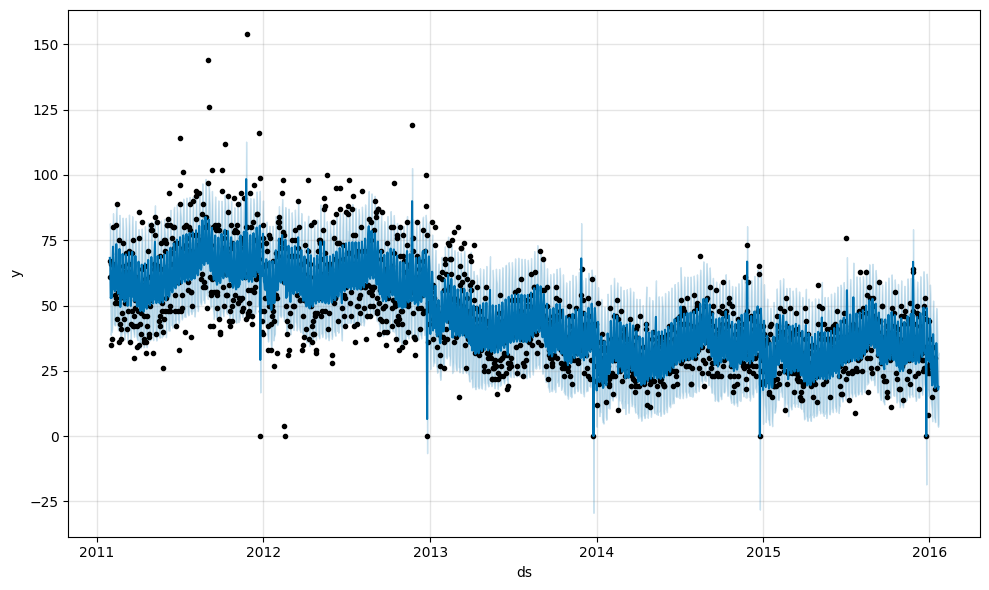

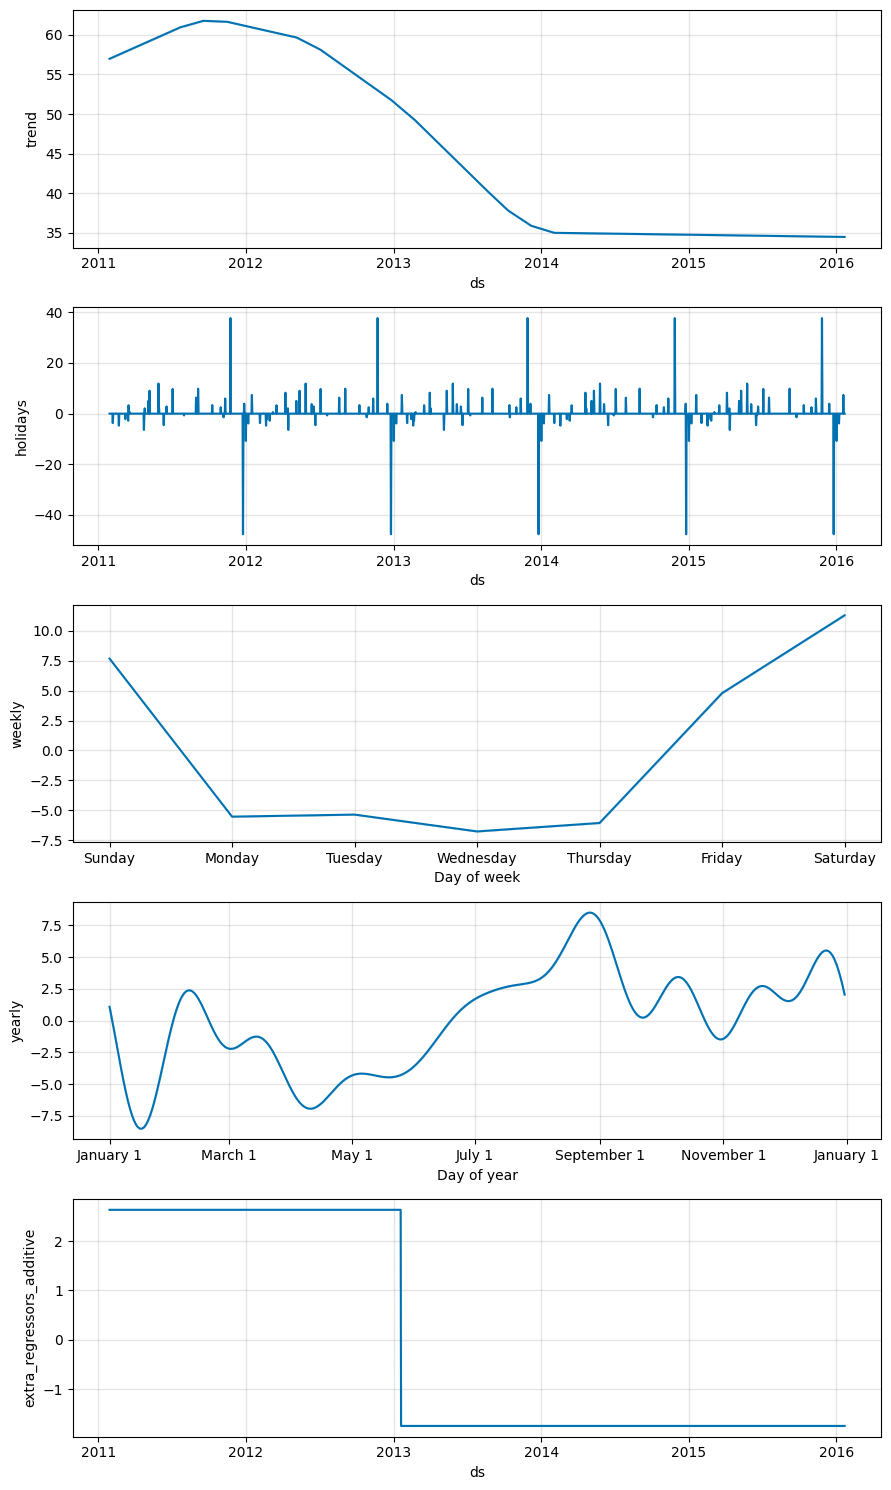

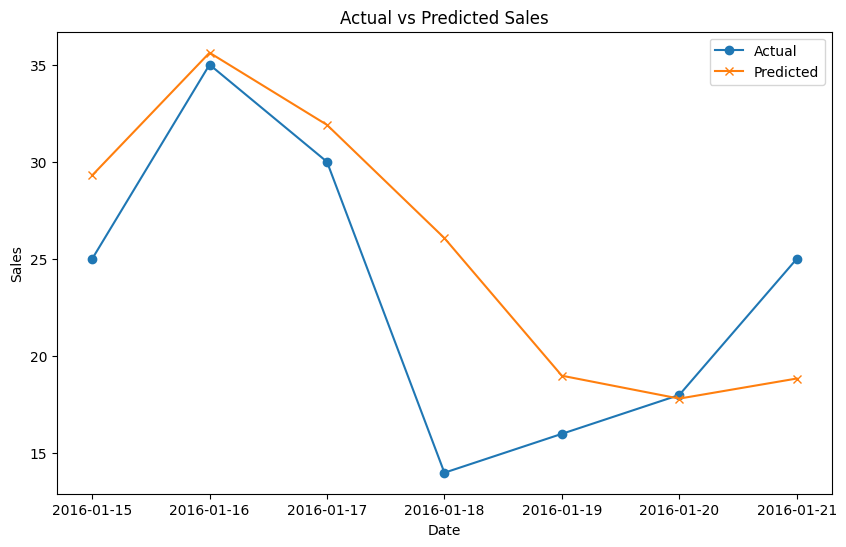

01:35:03 - cmdstanpy - INFO - Chain [1] start processing


Week - MSE: 30.73070446513182, MAE: 4.0312185499809745, MAPE: 22.266946098457215%


01:35:03 - cmdstanpy - INFO - Chain [1] done processing


Mean Squared Error: 117.289499641272
Mean Absolute Error: 8.004715955519291
MAPE: 36.03499612925683%


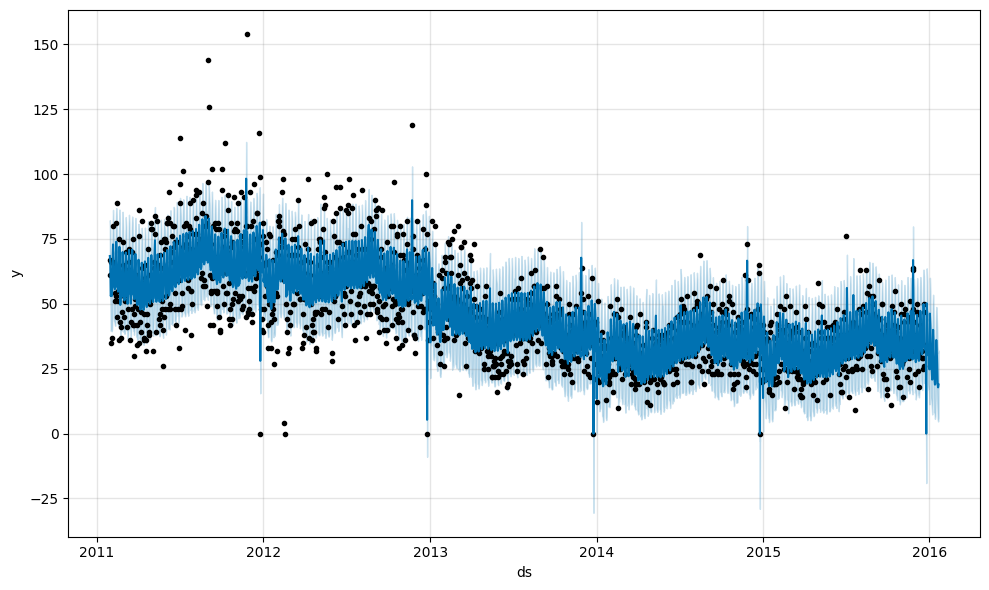

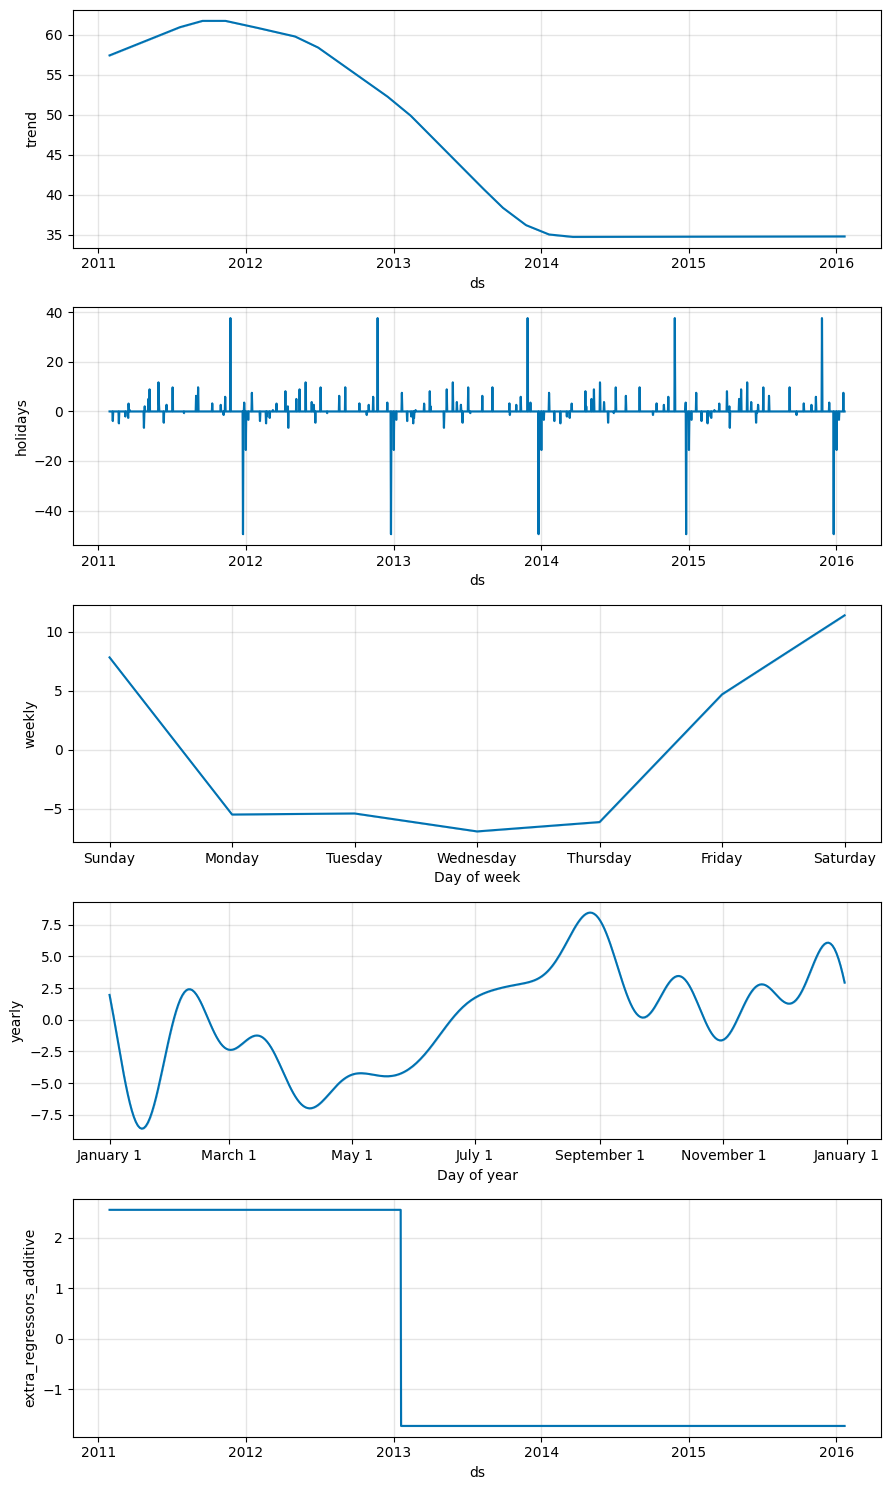

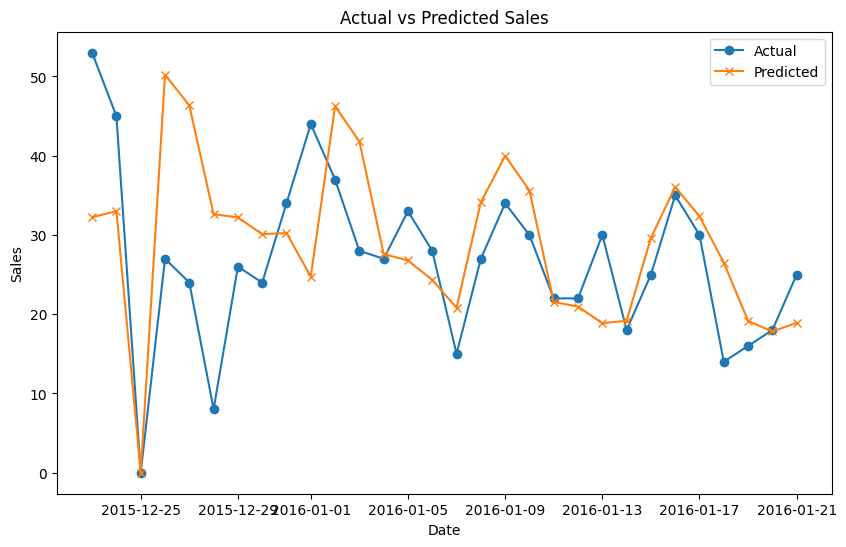

Month - MSE: 117.289499641272, MAE: 8.004715955519291, MAPE: 36.03499612925683%


01:35:05 - cmdstanpy - INFO - Chain [1] start processing
01:35:05 - cmdstanpy - INFO - Chain [1] done processing


Mean Squared Error: 76.73700664257157
Mean Absolute Error: 6.550221162493059
MAPE: 24.361907874192575%


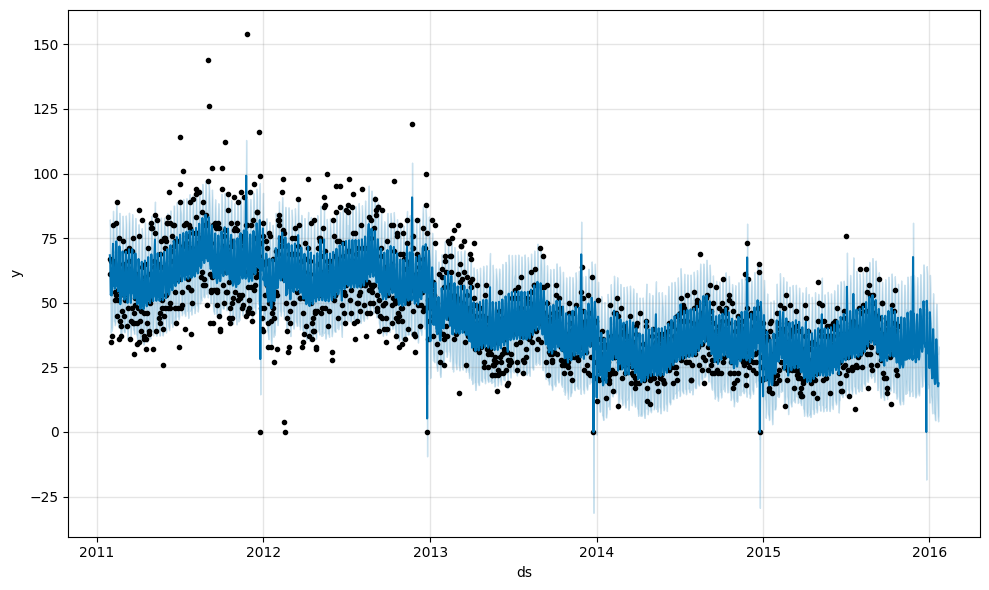

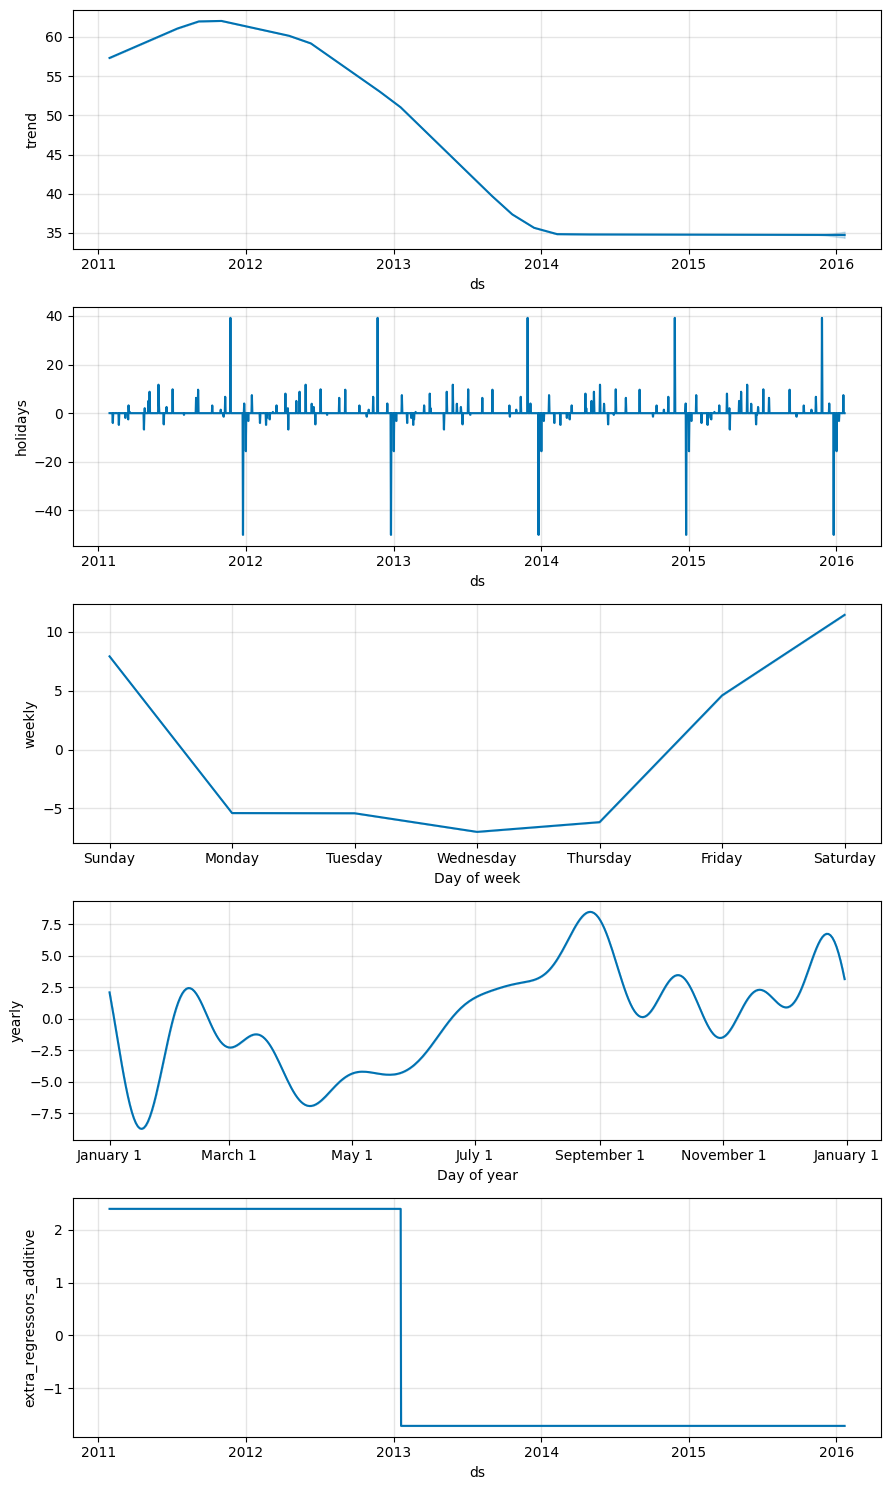

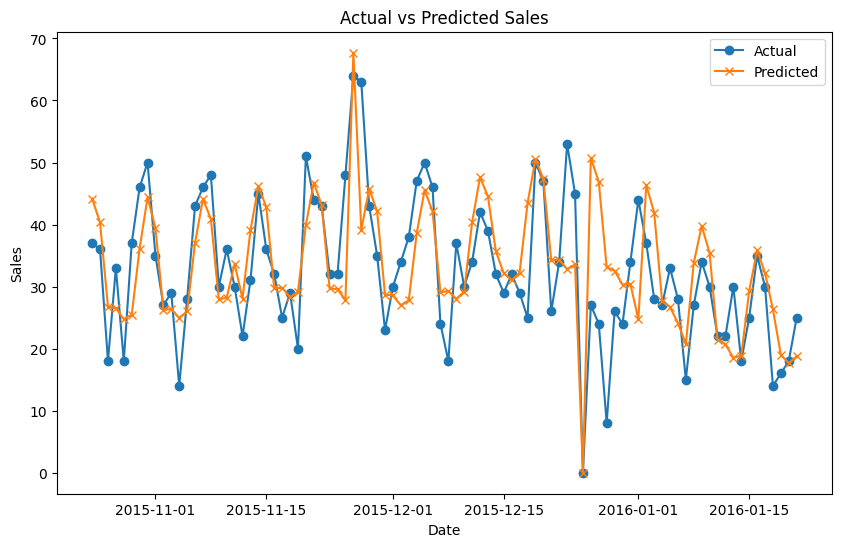

01:35:07 - cmdstanpy - INFO - Chain [1] start processing


Quarter - MSE: 76.73700664257157, MAE: 6.550221162493059, MAPE: 24.361907874192575%


01:35:07 - cmdstanpy - INFO - Chain [1] done processing
01:35:07 - cmdstanpy - INFO - Chain [1] start processing


Future Week Predictions:              ds       yhat
1819 2016-01-22  29.968525
1820 2016-01-23  36.994225
1821 2016-01-24  33.938309
1822 2016-01-25  21.347522
1823 2016-01-26  22.182947
1824 2016-01-27  21.492205
1825 2016-01-28  22.943818


01:35:08 - cmdstanpy - INFO - Chain [1] done processing
01:35:08 - cmdstanpy - INFO - Chain [1] start processing


Future Month Predictions:              ds       yhat
1819 2016-01-22  29.968525
1820 2016-01-23  36.994225
1821 2016-01-24  33.938309
1822 2016-01-25  21.347522
1823 2016-01-26  22.182947
1824 2016-01-27  21.492205
1825 2016-01-28  22.943818
1826 2016-01-29  34.497058
1827 2016-01-30  41.741952
1828 2016-01-31  38.813729
1829 2016-02-01  26.258932
1830 2016-02-02  27.040382
1831 2016-02-03  26.209311
1832 2016-02-04  27.439603
1833 2016-02-05  38.697502
1834 2016-02-06  45.581416
1835 2016-02-07  42.236156
1836 2016-02-08  29.218799
1837 2016-02-09  29.503392
1838 2016-02-10  28.152812
1839 2016-02-11  28.852733
1840 2016-02-12  39.581050
1841 2016-02-13  45.947427
1842 2016-02-14  42.107274
1843 2016-02-15  28.627387
1844 2016-02-16  28.490443
1845 2016-02-17  26.766688
1846 2016-02-18  27.147765
1847 2016-02-19  37.616035
1848 2016-02-20  43.784061


01:35:08 - cmdstanpy - INFO - Chain [1] done processing


Future Quarter Predictions:              ds       yhat
1819 2016-01-22  29.968525
1820 2016-01-23  36.994225
1821 2016-01-24  33.938309
1822 2016-01-25  21.347522
1823 2016-01-26  22.182947
...         ...        ...
1904 2016-04-16  37.411770
1905 2016-04-17  33.939121
1906 2016-04-18  20.885304
1907 2016-04-19  21.220474
1908 2016-04-20  20.002023

[90 rows x 2 columns]


In [389]:
# Загрузка данных
sales_data = pd.read_csv('shop_sales.csv')
calendar_data = pd.read_csv('shop_sales_dates.csv')
prices_data = pd.read_csv('shop_sales_prices.csv')

# Создание экземпляра класса RetailSalesPredictor
predictor = RetailSalesPredictor(sales_data, calendar_data, prices_data)

# Оценка качества модели на тестовой выборке
model_week, mse_week, mae_week, mape_week = predictor.forecast_week('STORE_1', 'STORE_1_586')
print(f'Week - MSE: {mse_week}, MAE: {mae_week}, MAPE: {mape_week}%')

model_month, mse_month, mae_month, mape_month = predictor.forecast_month('STORE_1', 'STORE_1_586')
print(f'Month - MSE: {mse_month}, MAE: {mae_month}, MAPE: {mape_month}%')

model_quarter, mse_quarter, mae_quarter, mape_quarter = predictor.forecast_quarter('STORE_1', 'STORE_1_586')
print(f'Quarter - MSE: {mse_quarter}, MAE: {mae_quarter}, MAPE: {mape_quarter}%')

# Предсказание будущих значений
future_week = predictor.predict_week('STORE_1', 'STORE_1_586')
print(f'Future Week Predictions: {future_week}')

future_month = predictor.predict_month('STORE_1', 'STORE_1_586')
print(f'Future Month Predictions: {future_month}')

future_quarter = predictor.predict_quarter('STORE_1', 'STORE_1_586')
print(f'Future Quarter Predictions: {future_quarter}')

# Сохранение модели
predictor.save_model(model_week, 'model_week.pkl')
predictor.save_model(model_month, 'model_month.pkl')
predictor.save_model(model_quarter, 'model_quarter.pkl')

# Загрузка модели
loaded_model_week = predictor.load_model('model_week.pkl')
loaded_model_month = predictor.load_model('model_month.pkl')
loaded_model_quarter = predictor.load_model('model_quarter.pkl')
